In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import os
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
from tqdm import tqdm
import matplotlib.pyplot as plt

# load data

In [2]:
path = os.getcwd()
par = os.path.abspath(os.path.join(path, os.pardir))

data_path = os.path.join(par,'3_generate_features','dimensionless_cropped_final_feature_array.csv')
label_path = os.path.join(par,'3_generate_features','final_label_array.csv')

os.path.isfile(data_path)


True

# preprocess features

In [5]:
#Turn into DF
prototype_df = pd.read_csv(data_path)
label_df = pd.read_csv(label_path)

#Drop formula column
# prototype_df = prototype_df.drop(columns='Formula')
prototype_df.head()

# filter for the most important features

most_important_features = pd.read_csv('features_prepruned/15_iteration_feature_8_features.csv')

feature_names_to_keep = most_important_features['Name'].to_numpy()

prototype_df = prototype_df[feature_names_to_keep]

# preprocess labels

In [6]:
#Dataframe convert label into categorical variable for classification
#Then convert labels into numpy array
label_name = 'Prototype'
label_df[label_name]= pd.Categorical(label_df[label_name])
label_df['numeric_label'] = label_df[label_name].cat.codes

#Convert numerical dataframe column to array
labels = label_df['numeric_label'].to_numpy()

label_df.head()


,Prototype,numeric_label
0,Anatase#TiO2,18
1,Cristobalite#SiO2,114
2,Rutile#TiO2,298
3,Laves(2H)#MgZn2,201
4,Quartz(low)#SiO2,287


# more preprocessing

In [7]:
#Function to change multiclass classification to 1 vs all
def multiclass_to_binary(labels, most_common_id):
    to_binary = lambda val: 1 if val == most_common_id else 0
    to_binary_vec = np.vectorize(to_binary)

    labels_1vsall = to_binary_vec(labels)

    return labels_1vsall

#Convert features to numpy
#Also define feature names for symbolic regression

features = prototype_df.to_numpy()
feature_names = list(prototype_df.columns)

#Define most class id of interest and relabel
id_ofinterest = 203

labels_1vsall = multiclass_to_binary(labels, most_common_id=203)

# define function for subsampling

In [8]:
# #Set rng seed and permutation of data examples for training
# rng = check_random_state(5)

#Check number of dominant class examples
n_positive_class = np.sum(labels_1vsall)

def subsample_data(features,labels_1vsall,n_subsample):

    rng = np.random.default_rng()

    #Dominant class boolean index
    positive_class_mask = labels_1vsall==1
    
    #Dominant class indexing to grab for training/test set (we want 50/50 representation)
    SR_features_train = features[positive_class_mask,:]
    SR_target_train = labels_1vsall[positive_class_mask]

    #Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
    SR_negative_train = features[~positive_class_mask,:]
    SR_negative_target = labels_1vsall[~positive_class_mask]

    #Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
    subsample_idx = rng.permutation(SR_negative_target.size)[:n_subsample]

    #Concatenate an equal amount of negative training data to the list of positive training data so we have 50/50 class representation
    SR_features = np.concatenate((SR_features_train, SR_negative_train[subsample_idx,:]),axis=0)
    SR_targets = np.concatenate((SR_target_train, SR_negative_target[subsample_idx]), axis=0)

    return SR_features, SR_targets


# define function to run the RF

In [9]:
def run_random_forest(features,targets):
    #Stratified K fold (maintain class balance)

    skf = StratifiedKFold(n_splits=10)

    cv_precisions = []
    cv_recalls = []

    for i, (train_idx, test_idx) in enumerate(skf.split(features,targets)):
        train_features_i = features[train_idx]
        train_labels_i = targets[train_idx]

        test_features_i = features[test_idx]
        test_labels_i = targets[test_idx]

        #Fit naive rf model
        naive_rf_i = RandomForestClassifier()
        naive_rf_i.fit(train_features_i, train_labels_i)
        
        predict_labels_i = naive_rf_i.predict(test_features_i)

        #Fit on k-folded validation set
        precision, recall = precision_score(test_labels_i, predict_labels_i), recall_score(test_labels_i, predict_labels_i)

        cv_precisions += [precision]
        cv_recalls += [recall]

    return np.mean(cv_precisions), np.mean(cv_recalls)

# run ML for varying subsample sizes

In [10]:
n_trials = 10

subsample_sizes = [int(x) for x in n_positive_class * np.array([0.1,0.3,0.5,0.8,1,1.5,2,2.5,3])]

subsample_size_cv_precisions = []
subsample_size_cv_recalls = []

for n_subsample in tqdm(subsample_sizes,desc='Subsample Sizes'):

    trials_cv_precisions = []
    trials_cv_recalls = []

    for n_trial in tqdm(range(n_trials),desc='Trials'):
        subsampled_features, subsampled_targets = subsample_data(features,labels_1vsall,n_subsample)

        cv_precision, cv_recall = run_random_forest(subsampled_features,subsampled_targets)

        trials_cv_precisions += [cv_precision]
        trials_cv_recalls += [cv_recall]
    
    subsample_size_cv_precisions += [trials_cv_precisions]
    subsample_size_cv_recalls += [trials_cv_recalls]


Subsample Sizes:  11%|█         | 1/9 [00:08<01:11,  8.98s/it]


KeyboardInterrupt: 

# plot accuracies in a figure

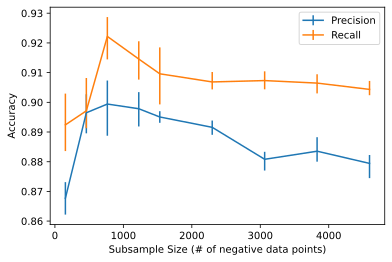

In [ ]:
precision_means = np.mean(subsample_size_cv_precisions,axis=1)
recall_means = np.mean(subsample_size_cv_recalls,axis=1)

precision_max = np.max(subsample_size_cv_precisions,axis=1)
precision_min = np.min(subsample_size_cv_precisions,axis=1)

recall_max = np.max(subsample_size_cv_recalls,axis=1)
recall_min = np.min(subsample_size_cv_recalls,axis=1)

plt.errorbar(subsample_sizes,precision_means,yerr=[precision_means-precision_min,precision_max-precision_means],label='Precision')
plt.errorbar(subsample_sizes,recall_means,yerr=[recall_means-recall_min,recall_max-recall_means],label='Recall')
plt.xlabel('Subsample Size (# of negative data points)')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/dimensionless_RF_subsampling_size_vs_accuracy.png',dpi=300)